# Fine-tuning InceptionV3 for flowers classification

In this programming assignment you will fine-tune InceptionV3 architecture for flowers classification task.

InceptionV3 architecture (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html):
<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week03/images/inceptionv3.png?raw=1" style="width:70%">

Flowers classification dataset (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) consists of 102 flower categories commonly occurring in the United Kingdom. Each class contains between 40 and 258 images:
<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week03/images/flowers.jpg?raw=1" style="width:70%">

In [1]:
%%bash

shred -u setup_colab.py

wget https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py -O setup_colab.py

shred: setup_colab.py: failed to open for writing: No such file or directory
--2021-03-17 22:33:28--  https://raw.githubusercontent.com/hse-aml/intro-to-dl-pytorch/main/utils/setup_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1649 (1.6K) [text/plain]
Saving to: ‘setup_colab.py’

     0K .                                                     100% 27.3M=0s

2021-03-17 22:33:28 (27.3 MB/s) - ‘setup_colab.py’ saved [1649/1649]



In [2]:
import setup_colab

setup_colab.setup_week03_2()

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import random
import tqdm
import collections
from IPython import display

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split

In [4]:
# auxiliary stuff
def calculate_accuracy(prediction, target):
    # Note that prediction.shape == target.shape == [B, ]
    
    matching = (prediction == target).float()
    return matching.mean()


class AverageMeter:
    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Fill in your Coursera token and email
To successfully submit your answers to our grader, please fill in your Coursera submission token and email.

In [5]:
import grading 

grader = grading.Grader(
    assignment_key="2v-uxpD7EeeMxQ6FWsz5LA", 
    all_parts=["wuwwC", "qRsZ1"]
)

In [48]:
# token expires every 30 min
COURSERA_TOKEN = 'DhGLBi1Cr7Ssb32q'
COURSERA_EMAIL = 'zavarovkv@gmail.com'

# Load dataset

Dataset was downloaded for you, it takes 12 min and 400mb.
Relevant links (just in case):
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

In [8]:
import download_utils

download_utils.download_week_3_resources('flowers')

**************************************************
102flowers.tgz
**************************************************
imagelabels.mat


In [9]:
# unpack data into flowers/
!tar -zxvf flowers/102flowers.tgz -C flowers/

Streaming output truncated to the last 5000 lines.
jpg/image_02266.jpg
jpg/image_00062.jpg
jpg/image_05821.jpg
jpg/image_03712.jpg
jpg/image_01142.jpg
jpg/image_03033.jpg
jpg/image_05760.jpg
jpg/image_02732.jpg
jpg/image_00183.jpg
jpg/image_05264.jpg
jpg/image_03778.jpg
jpg/image_07061.jpg
jpg/image_04468.jpg
jpg/image_00676.jpg
jpg/image_07610.jpg
jpg/image_02192.jpg
jpg/image_05112.jpg
jpg/image_05638.jpg
jpg/image_00053.jpg
jpg/image_02451.jpg
jpg/image_05857.jpg
jpg/image_08033.jpg
jpg/image_03902.jpg
jpg/image_07494.jpg
jpg/image_02357.jpg
jpg/image_05496.jpg
jpg/image_04496.jpg
jpg/image_07538.jpg
jpg/image_01801.jpg
jpg/image_00326.jpg
jpg/image_07644.jpg
jpg/image_01199.jpg
jpg/image_01168.jpg
jpg/image_07020.jpg
jpg/image_05006.jpg
jpg/image_03484.jpg
jpg/image_02825.jpg
jpg/image_04549.jpg
jpg/image_02011.jpg
jpg/image_04360.jpg
jpg/image_06847.jpg
jpg/image_07695.jpg
jpg/image_03540.jpg
jpg/image_08058.jpg
jpg/image_01230.jpg
jpg/image_00096.jpg
jpg/image_01517.jpg
jpg/image

In [10]:
from scipy.io import loadmat

# `datasets.ImageFolder` is a generic data loader
# where the images are arranged in this way:
#     root/dog/xxx.png
#     root/dog/xxy.png
#     root/dog/xxz.png
#     ...
#     root/cat/123.png
#     root/cat/nsdf3.png
#     root/cat/asd932_.png

class FlowersDataset(datasets.ImageFolder):
    
    def __init__(self, path: str, transform = None):
        super(FlowersDataset, self).__init__(path, transform=transform)
        
        # load labels from `*.mat` file
        self.labels = loadmat(f'{path}/imagelabels.mat')['labels'][0] - 1
        self.labels = self.labels.tolist()
        self.classes = list(set(self.labels))
    
    def __getitem__(self, index: int):
        image, _ = super().__getitem__(index)
        label = self.labels[index]
        return image, label
    
    def __len__(self):
        return len(self.labels)

In [11]:
dataset = FlowersDataset('flowers', transforms.PILToTensor())

76


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:169: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  img = torch.as_tensor(np.asarray(pic))


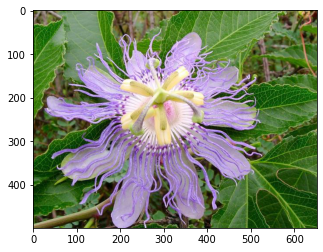

In [12]:
image, label = dataset[232]
print(label)
plt.imshow(image.permute(1, 2, 0))

## Prepare images for model

We will take a center crop from each image like this:
<img src="https://github.com/hse-aml/intro-to-dl-pytorch/blob/main/week03/images/center_crop.jpg?raw=1" style="width:50%">

And then resize image to IMG_SIZE x IMG_SIZE, where IMG_SIZE = 299

In [24]:
IMAGE_SIZE = 299

class CenterCrop2(nn.Module):
    
    def __init__(self):
        super(CenterCrop2, self).__init__()
    
    def forward(self, image: torch.Tensor):
        h, w = image.shape[-2:]
        
        s = h if w > h else w

        image = image[:, (h-s)//2:(h+s)//2, (w-s)//2:(w+s)//2]
        
        return image

prepare_transforms = transforms.Compose([
    transforms.PILToTensor(),
    
    # Convert from uint8 ([0, 255]) to float32 ([0.0, 0.1])
    transforms.Lambda(lambda image: image.float() / 255.),
    
    # Center crop
    CenterCrop2(),
    transforms.Resize(IMAGE_SIZE),

    # Normalization
    # This is necessary because the original model was trained
    # with normalization and expects normalized input
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [25]:
dataset = FlowersDataset('flowers', prepare_transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 299, 299]) 76


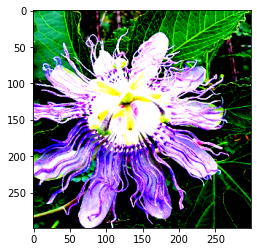

In [32]:
image, label = dataset[232]
print(image.shape, label)
plt.imshow(image.permute(1, 2, 0))

In [33]:
dummy_image = torch.rand((3, 300, 250))
cropped_image = CenterCrop2().forward(dummy_image)

In [35]:
# GRADED PART, DO NOT CHANGE!
grader.set_answer("qRsZ1", cropped_image.shape)

In [36]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## Split into train/test

In [37]:
indexes = list(range(len(dataset)))
train_indexes, test_indexes = train_test_split(
    indexes,
    test_size=0.2,
    random_state=42,
    stratify=dataset.labels
)

In [38]:
train_dataset = torch.utils.data.Subset(dataset, train_indexes)
test_dataset = torch.utils.data.Subset(dataset, test_indexes)

In [39]:
assert (len(train_dataset) + len(test_dataset)) == len(dataset)

In [40]:
BATCH_SIZE = 32

# `pin_memory` speed up processing if you use GPU
# `num_workers` also speed up processing since use additional process
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=4, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

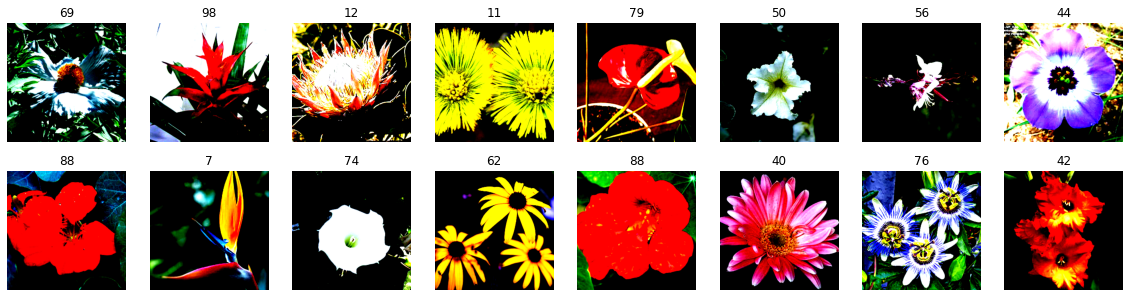

In [41]:
cols = 8
rows = 2

fig = plt.figure(figsize=(20, 5))

for i in range(cols):
    for j in range(rows):
        random_index = random.randint(0, len(train_dataset) - 1)
        
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        
        image, label = train_dataset[random_index]
        
        # move the channel dimension to the end
        images = image.permute(1, 2, 0)
        
        ax.imshow(images)
        ax.set_title(label)

plt.show()

# Training model

You cannot train such a huge architecture from scratch with such a small dataset.

But using fine-tuning of last layers of pre-trained network you can get a pretty good classifier very quickly.

In [42]:
class PretrainedInceptionV3(nn.Module):
    
    def __init__(self, output_dim: int):
        super(PretrainedInceptionV3, self).__init__()
        
        # Download pretrained model and turn on eval regime
        self.barebone = models.inception.inception_v3(
            pretrained=True, progress=True, aux_logits=False
        )
        
        # Freeze all layers
        for p in self.barebone.parameters():
            p.requires_grad_(False)
        
        # Unfreeze penultimate block
        # The network will adjust faster to new data
        for p in self.barebone.Mixed_7c.parameters():
            p.requires_grad_(True)
        
        # Replace the last Linear layer
        in_features_final_fc = self.barebone.fc.in_features
        self.barebone.fc = nn.Linear(in_features_final_fc, output_dim)
    
    def forward(self, input: torch.Tensor):
        return self.barebone(input)

## Init train pipeline

In [43]:
NUM_EPOCH = 20
DEVICE = torch.device('cuda:0')
HISTORY = collections.defaultdict(list)

model = PretrainedInceptionV3(output_dim=len(train_dataset.dataset.classes)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-2
)

# Set up learning rate scheduler
# This will speed up the convergence of the model
lr_scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer=optimizer,
    milestones=[7, 15],
    gamma=0.1,
    verbose=True
)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



Adjusting learning rate of group 0 to 1.0000e-02.


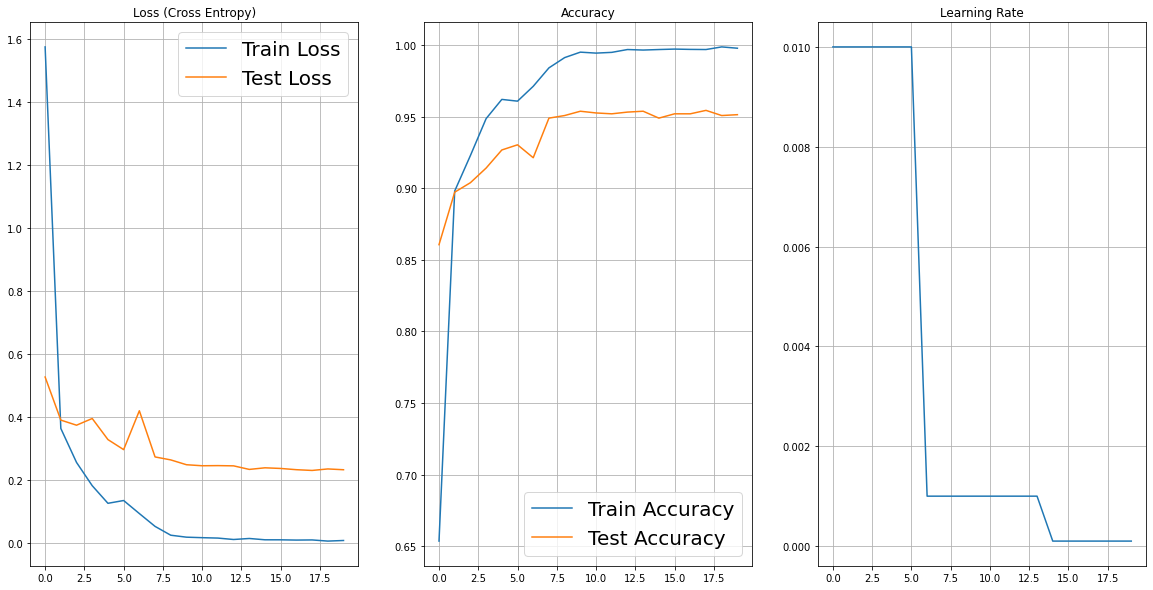

In [44]:
for epoch in range(NUM_EPOCH):
    # AverageMeter will accumulate average of some metric
    train_loss_meter = AverageMeter()
    train_accuracy_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    test_accuracy_meter = AverageMeter()
    
    # training loop
    # sets the module in training mode -- it i  s important for nn.Dropout
    model.train()
    # wrap `train_dataloader` within tqdm to visualize progress
    for train_batch in tqdm.tqdm(train_dataloader):
        
        # unpack batch and move to specific device (for example, GPU or TPU)
        images, labels = train_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # do forward pass
        logits = model.forward(images)
        prediction = logits.argmax(dim=-1)
        
        # calculate loss (CrossEntropy)
        loss = criterion(logits, labels)
        
        # zero out the previous gradients of our model parameters
        optimizer.zero_grad()
        
        # calculate new gradients
        loss.backward()
        
        # do optimization step
        optimizer.step()
        
        # calculate current average loss and accuracy
        train_loss_meter.update(loss.item())
        train_accuracy_meter.update(
            calculate_accuracy(
                prediction.detach(),
                labels
            ).item()
        )
    
    # update lr_scheduler
    lr_scheduler.step()
        
    # save average train loss and accuracy
    HISTORY['train_loss'].append(train_loss_meter.avg)
    HISTORY['train_accuracy'].append(train_accuracy_meter.avg)
    
    # lr_scheduler.get_last_lr() return list of LRs (one LR for each group)
    HISTORY['learning_rate'].append(lr_scheduler.get_last_lr()[0])
        
    # testing loop
    # sets the module in evaluation mode
    model.eval()
    for test_batch in test_dataloader:
        images, labels = test_batch
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        
        # аdd `with torch.no_grad()' to avoid computing gradients of weights
        with torch.no_grad():
            # do everything like we did in training loop
            logits = model(images)
            prediction = logits.argmax(dim=-1)
            loss = criterion(logits, labels)
        
        test_loss_meter.update(loss.item())
        test_accuracy_meter.update(
            calculate_accuracy(
                prediction,
                labels
            ).item()
        )
    
    # save average test accuracy loss and accuracy
    HISTORY['test_loss'].append(test_loss_meter.avg)
    HISTORY['test_accuracy'].append(test_accuracy_meter.avg)
    
    # visualize all togather
    display.clear_output()
    fig, axes = plt.subplots(1, 3, figsize=(20, 10))
    
    axes[0].set_title('Loss (Cross Entropy)')
    axes[0].plot(HISTORY['train_loss'], label='Train Loss')
    axes[0].plot(HISTORY['test_loss'], label='Test Loss')
    axes[0].grid()
    axes[0].legend(fontsize=20)
    
    axes[1].set_title('Accuracy')
    axes[1].plot(HISTORY['train_accuracy'], label='Train Accuracy')
    axes[1].plot(HISTORY['test_accuracy'], label='Test Accuracy')
    axes[1].grid()
    axes[1].legend(fontsize=20)
    
    axes[2].set_title('Learning Rate')
    axes[2].plot(HISTORY['learning_rate'])
    axes[2].grid()
    
    plt.show()

In [45]:
assert max(HISTORY['test_accuracy']) > 0.95

In [49]:
## GRADED PART, DO NOT CHANGE!
grader.set_answer("wuwwC", max(HISTORY['test_accuracy']))

In [50]:
# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
